# Feature Selecection

In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

# Import Preporcessed Data

In [2]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date" , inplace=True)

# Add prediction target

In [3]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["AVG_Range"] , "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["AVG_Range"] , "TARGET"] = 0

In [4]:
# Check for NAN
nan_location = np.where(np.isnan(df))

In [5]:
# Fill NaNs
df["TARGET"].fillna(0,inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-23,0.003965,0.014381,0.010036,27225.726562,0.238807,0.013945,0.023065,3.144802,46.178235,1.112756,...,1,-0.009218,0.032783,0.003643,0.018682,-0.031291,-0.013851,0.020931,-0.015115,1.0
2023-05-24,0.013727,-0.007657,-0.026462,26334.818359,0.189959,-0.032723,0.042826,3.008356,38.323938,0.829913,...,2,-0.039547,0.033091,0.013945,0.023065,-0.009218,0.003643,0.018682,-0.031291,0.0
2023-05-25,-0.032880,-0.023254,-0.008273,26476.207031,-0.150191,0.005369,0.027073,3.029568,40.066179,1.045461,...,3,-0.062598,0.032569,-0.032723,0.042826,-0.039547,0.013945,0.023065,-0.009218,0.0
2023-05-26,0.005497,0.012228,0.017510,26719.291016,-0.082268,0.009181,0.021740,3.066700,43.045036,1.074348,...,4,-0.057483,0.030035,0.005369,0.027073,-0.062598,-0.032723,0.042826,-0.039547,0.0
2023-05-27,0.009292,-0.001032,0.010522,26868.353516,-0.379150,0.005579,0.010058,3.089815,44.855043,1.042049,...,5,-0.088884,0.028646,0.009181,0.021740,-0.057483,0.005369,0.027073,-0.062598,0.0


# Train - Test SPLIT

In [6]:
# REMOVE UNWANTED COLUMNS (dont put information about the future in your data other than the target)
df_tts = df.copy()
df_tts.drop(columns=["Close", "Bench_C_Rets" , "Open", "High", "Low"], inplace=True)

In [7]:
# Split into Learning (X) and Target (y) data
X = df_tts.iloc[: , : -1 ]
y = df_tts.iloc[: ,   -1 ]

In [8]:
# Train Test Split
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size=0.2 , random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (968, 16)
Shape of y_train: (968,)


# Build Initial Model
- find the useful features

In [9]:
# Select type of model to optimize for
is_binary = True
is_optimize_for_precision = True

In [10]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error","logloss",eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror","mlogloss",eval_metric]

In [11]:
# Refine Eval Metric
if is_binary and is_optimize_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimize_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [12]:
# Build First Classifier Model
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Find Hyper-Parameters
- find optimal
    - estimators 
    - learning rate 
    - maximum depth
    - gamma

In [13]:
# Provide Grid for Hyper-Parameterss
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [14]:
# preform Random Search for Best Hyper Params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train,y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]


print("Recommended params >>" , f"ne: {ne}", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended params >> ne: 25 lr: 0.1 md: 1 gm: 0.1


# Train Model (xg-boost)

In [15]:
# Build First Classifier Model
classifier_1 = XGBClassifier(
    n_estimators = ne,
    learning_rate = lr,
    max_depth = md ,
    gamma = gm,
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Fit Model with Data

In [16]:
eval_set = [(X_train,y_train)]

classifier_1.fit(
    X_train,
    y_train ,
    eval_metric = eval_metric_list,
    eval_set = eval_set,
    verbose = False
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=25, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Performance Evaluation (quick overview)

In [18]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)

train_yhat[:5]

array([1, 1, 1, 0, 0])

In [19]:
# Cross validate
crossValidation  = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)

In [20]:
# Training Results 
train_results = cross_val_score(
    classifier_1,X_train,y_train,scoring=scoring,cv=crossValidation , n_jobs= 1
)

In [25]:
# Review Results 
print("Average Accuracy K-Fold: ", round(train_results.mean() , 2))
print("STD Deviation K-Fold: "   , round(train_results.std() , 2))
print("Precision score 0: "      , precision_score(y_train , train_yhat , average=None)[0])
print("Precision score 1: "      , precision_score(y_train , train_yhat , average=None)[1])

Average Accuracy K-Fold:  0.74
STD Deviation K-Fold:  0.11
Precision score 0:  0.6618141097424413
Precision score 1:  0.8533333333333334


# Feature Seletion
- a feature about xg-boost is that it can tell you wht features helped with making predictions

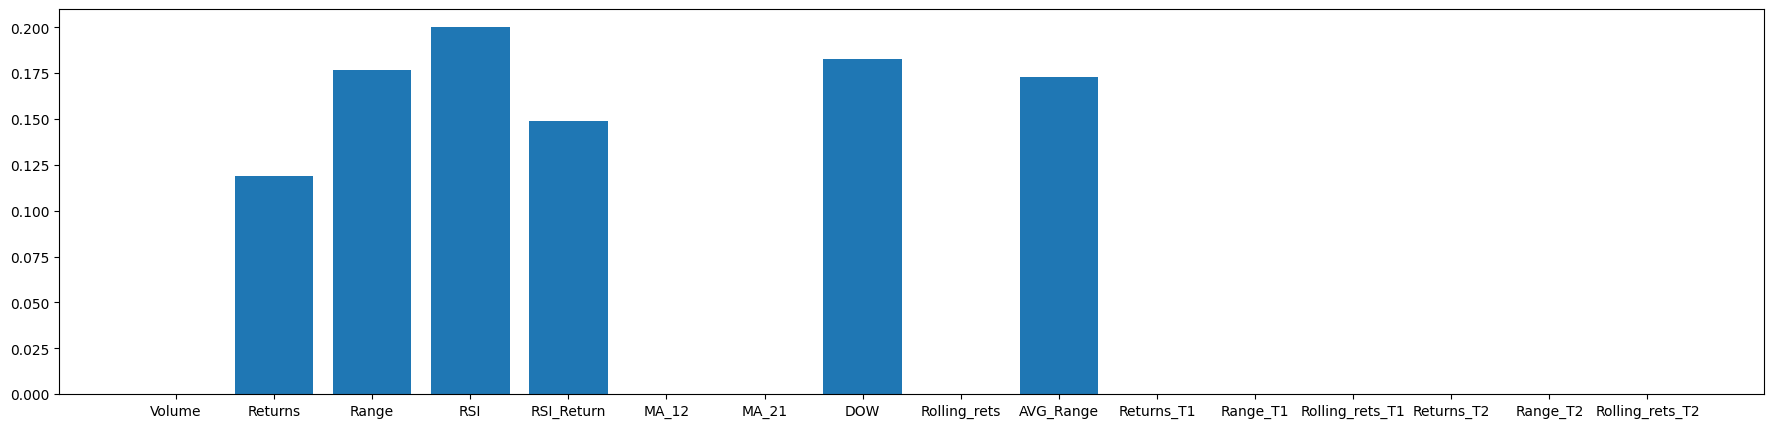

In [26]:
# Plot Feature Importancies
fig = plt.figure(figsize=(22,5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels , importance_features)
plt.show()

In [32]:
# SELECT BEST FEATURES
mean_of_feature_importance = importance_features.mean()
recommended_feature_labels = []
recommended_feature_score = []
for i in range(0, len(importance_features) , 1) :
    if importance_features[i] > mean_of_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(importance_features[i])

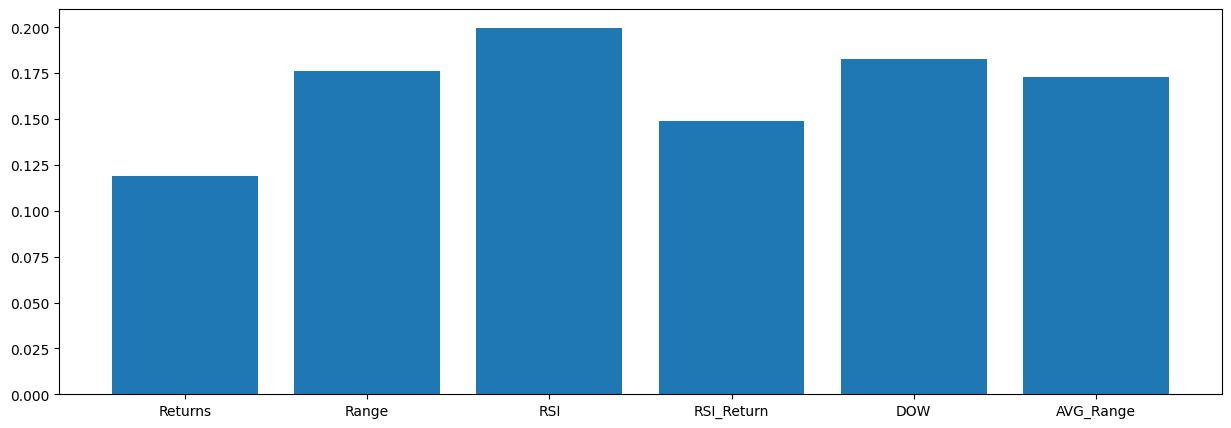

In [33]:
# plot recommended features
fig = plt.figure(figsize=(15,5))
plt.bar(recommended_feature_labels , recommended_feature_score)
plt.show()